![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


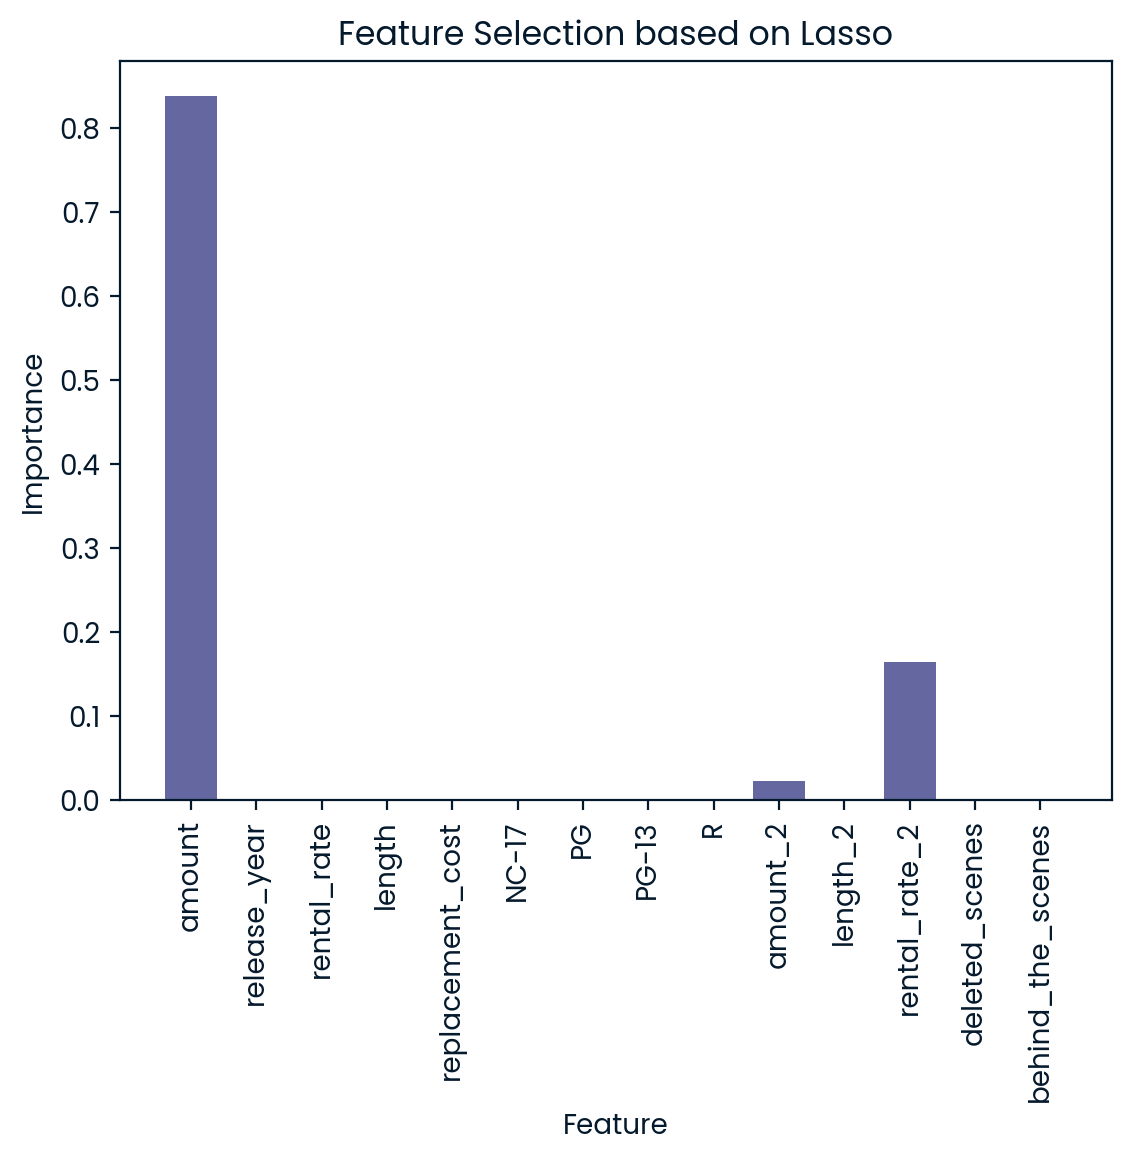

Ridge Regressor best parameters:  {'ridge__alpha': 0.3164736842105263}
Ridge Regressor best score on training set:  0.5689602949871087
KNN Regressor best parameters:  {'knn__n_neighbors': 47}
KNN Regressor best score on training set:  0.6506709321281542
Decision Tree Regressor best parameters:  {'max_depth': 4, 'min_samples_leaf': 0.1}
Decison Tree Regressor best score on training set:  0.5377457223290014
Ridge Regressor score on test set:  0.5644304176578403
KNN Regressor score on test set:  0.6496650971041837
Decision Tree Regressor score on test set:  0.5388464127386481
Ridge Regressor mean squared error:  3.092356969412933
KNN  Regressor mean squared error:  2.4872273513062986
Decision Tree Regressor mean squared error:  3.2739924167091825
GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 

In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# Import any additional modules and start coding below

## Preprocessing data
# Reading csv file and checking data types:
df = pd.read_csv("rental_info.csv")
df.info()

# Adding "rental_length_Days":
df[["rental_date", "return_date"]] = df[["rental_date", "return_date"]].apply(pd.to_datetime)
df["rental_length_days"] = (df["return_date"] - df["rental_date"]).dt.days

# Creating 2 columns of dummy variables:
df["deleted_scenes"] =  np.where(df["special_features"].str.contains("Deleted Scenes"), 1,0)
df["behind_the_scenes"] =  np.where(df["special_features"].str.contains("Behind the Scenes"), 1,0)
df.drop("special_features", axis = 1)

# Split data into sets:
seed = 9
X = df.drop(["rental_length_days","rental_date", "return_date", "special_features"], axis = 1)
y = df["rental_length_days"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=seed)

# Feature Selection with Lasso (alpha = 0.2) and visualization:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

names = df.drop(["rental_length_days","rental_date", "return_date", "special_features"], axis = 1).columns

lasso = Lasso(alpha = 0.2, random_state = seed)
lasso.fit(X_train, y_train)
lasso_coefs = np.abs(lasso.coef_)

names = df.drop(["rental_length_days","rental_date", "return_date", "special_features"], axis = 1).columns

plt.bar(names, lasso_coefs)
plt.xticks(rotation = 90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Selection based on Lasso")
plt.show()

selected_features = lasso_coefs > 0
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

## Models' fit on selected training set with GridSearch cross validation:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline  import Pipeline
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Ridge Regressor + pipeline
steps = [("scaler", StandardScaler()),("ridge", Ridge())]
pipeline = Pipeline(steps)
ridge_params =  { "ridge__alpha": np.linspace(0.001,1,20)}

cv_ridge = GridSearchCV(pipeline, ridge_params)
cv_ridge.fit(X_train_selected, y_train)
ridge_best_parameters = cv_ridge.best_params_
ridge_best_score = cv_ridge.best_score_

print("Ridge Regressor best parameters: ",ridge_best_parameters)
print("Ridge Regressor best score on training set: ",ridge_best_score)

# KNN regressor + pipeline
steps = [("scaler", StandardScaler()), ("knn", KNeighborsRegressor())]
pipeline = Pipeline(steps)
knn_params = { "knn__n_neighbors": np.arange(1,50)}

cv_knn = GridSearchCV(pipeline, knn_params)
cv_knn.fit(X_train_selected, y_train)
knn_best_parameters = cv_knn.best_params_
knn_best_score = cv_knn.best_score_

print("KNN Regressor best parameters: ",knn_best_parameters)
print("KNN Regressor best score on training set: ",knn_best_score)

# Decision Tree
dt = DecisionTreeRegressor(random_state = seed)
tree_params = {"max_depth":[2, 3, 4], "min_samples_leaf": np.linspace(0.10,0.20,5).astype(float)}

cv_tree = GridSearchCV(dt, tree_params)
cv_tree.fit(X_train_selected, y_train)
tree_best_parameters = cv_tree.best_params_
tree_best_score = cv_tree.best_score_

print("Decision Tree Regressor best parameters: ",tree_best_parameters)
print("Decison Tree Regressor best score on training set: ",tree_best_score)


## Models' predicitions on selected test set and mean squared error:
yhat_ridge = cv_ridge.predict(X_test_selected)
ridge_test_score = cv_ridge.score(X_test_selected, y_test)
print("Ridge Regressor score on test set: ",ridge_test_score)

yhat_knn = cv_knn.predict(X_test_selected)
knn_test_score = cv_knn.score(X_test_selected, y_test)
print("KNN Regressor score on test set: ",knn_test_score)

yhat_tree = cv_tree.predict(X_test_selected)
tree_test_score = cv_tree.score(X_test_selected, y_test)
print("Decision Tree Regressor score on test set: ",tree_test_score)

ridge_mse = MSE(y_test, yhat_ridge)
knn_mse = MSE(y_test, yhat_knn)
tree_mse = MSE(y_test, yhat_tree)

print("Ridge Regressor mean squared error: ",ridge_mse)
print("KNN  Regressor mean squared error: ",knn_mse)
print("Decision Tree Regressor mean squared error: ",tree_mse)

# Best Model
best_model = cv_knn
best_mse = knn_mse
print(best_model)
print("Best MSE is:",best_mse)
